In [ ]:
from os import makedirs
from os.path import basename, dirname, exists, join, realpath
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import math

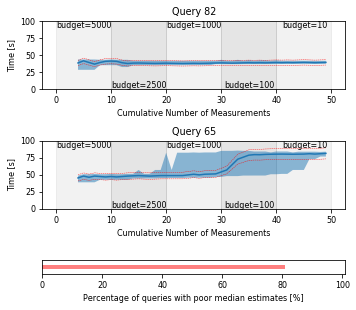

In [5]:

budgets = [5000, 2500, 1000, 100, 10]
small_budgets = [10, 100, 1000, 2500]

filedir = realpath("./")
inputdir = realpath(join(filedir, '../data/fig19/'))

def load_data(filename):
	df = pd.read_csv(join(inputdir, filename), sep = ",", names=["budget", "query", "time"])
	return df
	
def get_avg_per_budget(app_df):
	result = []
	for budget in budgets:
		runtimes = app_df.loc[app_df["budget"] == budget]
		result.append(np.mean(runtimes["time"]))
	return result
		
def get_avg_per_app(df, app):
	app_df = df.loc[df["query"] == app]
	result = np.mean(app_df["time"])
	return result
	
def compute_rsed(app):
	value = app[5000]
	sum = 0.0
	for budget in small_budgets:
		sum += (value - app[budget]) * (value - app[budget])
	return math.sqrt(sum / 4.0)
	
def get_mean_per_query(df, query):
	result = dict()
	for budget in budgets:
		budget_df = df.loc[df["budget"] == budget]
		res = get_avg_per_app(budget_df, query)
		result[budget] = res
		
	return result

def get_data_per_query(df, query):
	app_df = df.loc[df["query"] == query]
	result = []
	for budget in budgets:
		budget_df = app_df.loc[df["budget"] == budget]
		for value in budget_df["time"].values:
			result.append(value)
	return result

def median_ci(data, ci, p):
	data = np.sort(data)
	n = data.shape[0]
	z = 1.96
	low_ci = math.floor((n - z * math.sqrt(n)) / 2.0)
	hi_ci = math.floor((n + z * math.sqrt(n)) / 2.0)
	return data[int(low_ci)], data[int(hi_ci)]

def get_median_per_measurements(data):
	n_measurements = len(data)
	results = []
	low_ci = []
	high_ci = []
	error_1perc = []
	for i in range(4, n_measurements):
		crnt_median = np.median(data[:i])
		results.append(crnt_median)
		low, hi = median_ci(data[:i], 0.95, 0.5)
		low_ci.append(low)
		high_ci.append(hi)
		error_1perc.append(crnt_median * 0.1)
		#print crnt_median, median_ci(data[:i], 0.95, 0.5)
	return results, low_ci, high_ci, error_1perc
	
def plot_ci_per_query(ax, query):
	max_dev_data = get_data_per_query(data, query)
	medians, low_ci, high_ci, error_1perc = get_median_per_measurements(max_dev_data)

	ax.fill_between(np.arange(0, 11), [0] * 11, [100] * 11, alpha=0.1, color="grey")
	ax.fill_between(np.arange(10, 21), [0] * 11, [100] * 11, alpha=0.2, color="grey")
	ax.fill_between(np.arange(20, 31), [0] * 11, [100] * 11, alpha=0.1, color="grey")
	ax.fill_between(np.arange(30, 41), [0] * 11, [100] * 11, alpha=0.2, color="grey")
	ax.fill_between(np.arange(40, 51), [0] * 11, [100] * 11, alpha=0.1, color="grey")

	ax.plot(np.arange(4, len(medians) + 4), medians)
	ax.fill_between(np.arange(4, len(medians) + 4), low_ci, high_ci, alpha=0.5)

	low_y = 1#np.min(low_ci) - 5
	high_y = 100#np.max(high_ci) + 15
	ax.set_ylim(0, high_y)
	
	error_low = []
	error_high = []
	for i in range(0, len(medians)):
		error_low.append(medians[i] - error_1perc[i])
		error_high.append(medians[i] + error_1perc[i])
		
	ax.plot(np.arange(4, len(medians) + 4), error_low, color="red", lw=0.4, ls="--")
	ax.plot(np.arange(4, len(medians) + 4), error_high, color="red", lw=0.4, ls="--")
	
	ax.set_xlabel("Cumulative Number of Measurements")
	ax.set_ylabel("Time [s]")

	ax.text(0.1, high_y - high_y * 0.1, "budget=5000")
	ax.text(10.1, low_y + low_y * 0.1, "budget=2500")
	ax.text(20.09, high_y - high_y * 0.1, "budget=1000")
	ax.text(30.5, low_y + low_y * 0.1 , "budget=100")
	ax.text(41, high_y - high_y * 0.1, "budget=10")
	ax.set_title("Query " + str(query))
	
data = load_data("tpcds_budget_results.csv")
queries = data["query"].unique()
queries = [82, 65]

max_deviation = 0
max_dev_query = 0
for query in queries:
	app_runtime = get_mean_per_query(data, query)
	deviation = compute_rsed(app_runtime)
	if deviation > max_deviation:
		max_deviation = deviation
		max_dev_query = query
	#print(" ======= " + str(query) + " ========")
	#print(app_runtime)
	#print(deviation)
	#print("--------------------------------")

font = {'size': 8}
matplotlib.rc('font', **font)
	
aspect_ratios = [1] * len(queries)
aspect_ratios.append(0.2)
fig, ax = plt.subplots(nrows = len(queries)+1, ncols = 1, gridspec_kw = {'height_ratios':aspect_ratios}, figsize = (5, (len(queries) + 1) * 1.45))

for i in range(0, len(queries)):
	plot_ci_per_query(ax[i], queries[i])

last_ax = len(queries) 
ax[last_ax].set_ylim(0.5, 1.5)
ax[last_ax].set_yticks([])
ax[last_ax].barh([1],[81], height=0.3, color="red", alpha=0.5)
ax[last_ax].set_xlabel("Percentage of queries with poor median estimates [%]") 
ax[last_ax].set_xlim(0, 101)
ax[last_ax].set_xticks(np.arange(0, 101, 20))

#print(len(queries))
plt.tight_layout()

plt.show()